In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ttcrpy import rgrid

plt.style.use('seaborn')

# Résolution

On utilise un exemple de tomographie pour illustrer le concept de résolution des paramètres.

On défini un modèle comportant 16 paramètres

10 mesures sont réalisées

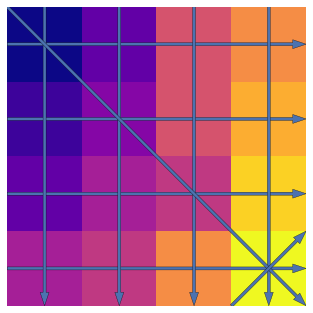

In [2]:
mtrue = np.array([1.0, 1.1, 1.2, 1.4,
                  1.2, 1.3, 1.4, 1.5,
                  1.6, 1.6, 1.5, 1.8,
                  1.8, 1.9, 2.0, 2.1])

h = 2

nx = 4
nz = 4

Tx = h*np.array([[0.0, 0.5],
                 [0.0, 1.5],
                 [0.0, 2.5],
                 [0.0, 3.5],
                 [0.5, 0.0],
                 [1.5, 0.0],
                 [2.5, 0.0],
                 [3.5, 0.0],
                 [0.0, 0.0],
                 [3.0, 4.0]])
Rx = h*np.array([[4.0, 0.5],
                 [4.0, 1.5],
                 [4.0, 2.5],
                 [4.0, 3.5],
                 [0.5, 4.0],
                 [1.5, 4.0],
                 [2.5, 4.0],
                 [3.5, 4.0],
                 [4.0, 4.0],
                 [4.0, 3.0]])

# coordonnées pour l'affichage des trajectoires des rais
Tx2 = Tx/h-0.5
Rx2 = Rx/h-0.5

plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
for n in range(Tx2.shape[0]):
    plt.arrow(Tx2[n, 0], Tx2[n, 1], Rx2[n, 0]-Tx2[n,0], Rx2[n, 1]-Tx2[n,1],
              width=0.04, length_includes_head=True)
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
plt.show()

### Construction de la matrice $\mathbf{G}$


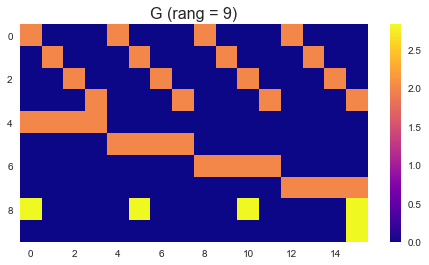

In [3]:
G = np.zeros((10, nx*nz))

G[0, ::4] = h
G[1, 1::4] = h
G[2, 2::4] = h
G[3, 3::4] = h
G[4, :4] = h
G[5, 4:8] = h
G[6, 8:12] = h
G[7, 12:16] = h
G[8, ::5] = np.sqrt(2*h*h)
G[9, -1] = np.sqrt(2*h*h)

p = np.linalg.matrix_rank(G)

plt.figure(figsize=(8, 4))
plt.imshow(G, cmap='plasma')
plt.grid()
plt.colorbar()
plt.title('G (rang = {0:g})'.format(p), fontsize=16)
plt.show()

### SVD

On va utiliser la décompostion en valeurs singulières pour faire cette étude

In [4]:
help(np.linalg.svd)

Help on function svd in module numpy.linalg:

svd(a, full_matrices=True, compute_uv=True, hermitian=False)
    Singular Value Decomposition.
    
    When `a` is a 2D array, it is factorized as ``u @ np.diag(s) @ vh
    = (u * s) @ vh``, where `u` and `vh` are 2D unitary arrays and `s` is a 1D
    array of `a`'s singular values. When `a` is higher-dimensional, SVD is
    applied in stacked mode as explained below.
    
    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex array with ``a.ndim >= 2``.
    full_matrices : bool, optional
        If True (default), `u` and `vh` have the shapes ``(..., M, M)`` and
        ``(..., N, N)``, respectively.  Otherwise, the shapes are
        ``(..., M, K)`` and ``(..., K, N)``, respectively, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether or not to compute `u` and `vh` in addition to `s`.  True
        by default.
    hermitian : bool, optional
        If True, `a` is assumed to be

### Calcul des matrices

In [5]:
dobs = G @ mtrue

U, s, Vh = np.linalg.svd(G)
V = Vh.T
S = np.diag(s)

Vp = V[:, :p]
V0 = V[:, p:]
Sp = np.diag(s[:p])
Up = U[:, :p]
U0 = U[:, p:]

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))

mest = Gi @ dobs
dpre = G @ mest

Rm = Vp @ Vp.T
Rd = Up @ Up.T

### Affichage du spectre des valeurs singulières



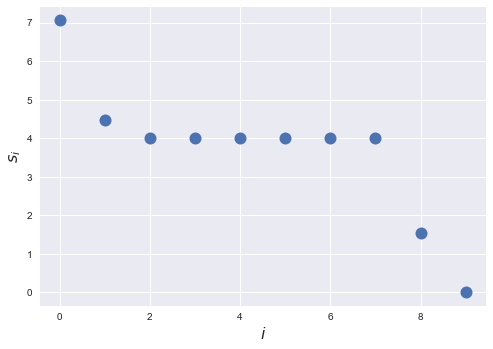

In [6]:
plt.plot(s, 'o', MarkerSize=12)
plt.ylabel('$s_i$', Fontsize=16)
plt.xlabel('$i$', Fontsize=16)
plt.show()

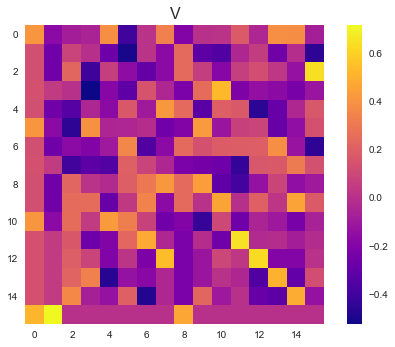

In [7]:
plt.imshow(V, cmap='plasma')
plt.grid()
plt.colorbar()
cl = plt.gci().get_clim()
plt.title('V', Fontsize=16)
plt.show()

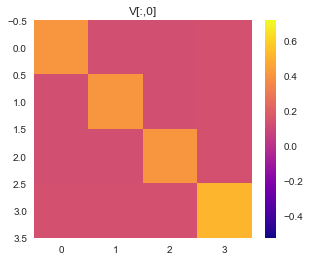

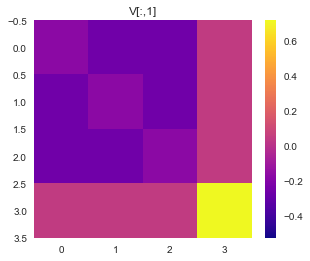

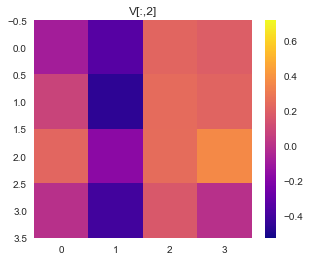

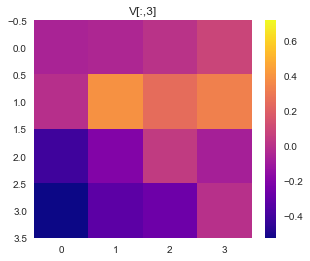

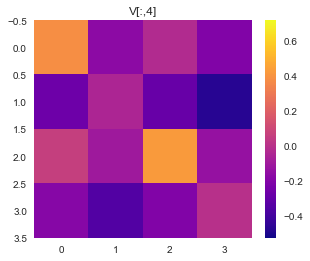

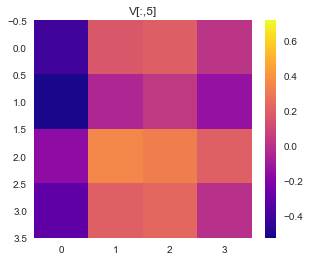

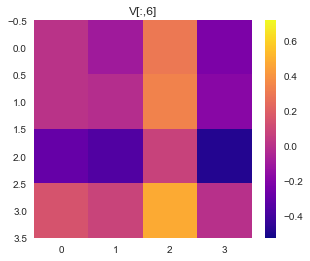

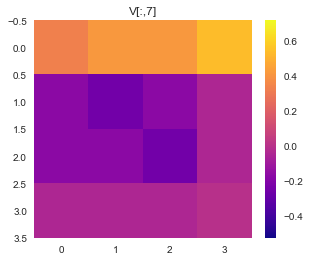

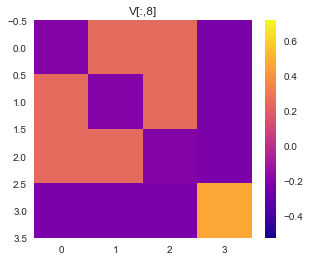

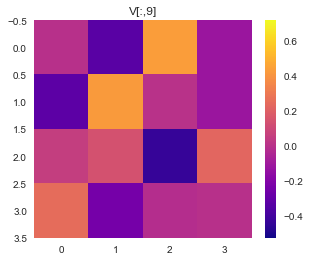

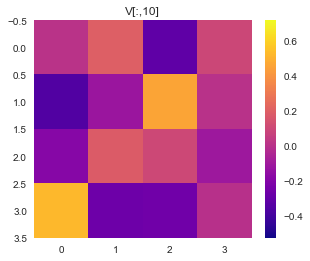

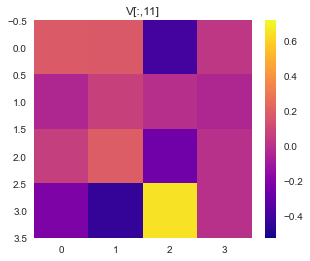

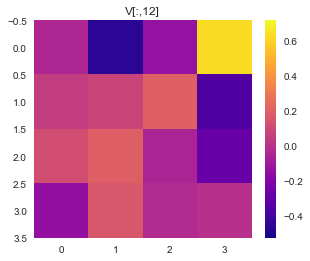

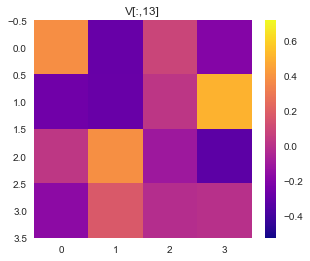

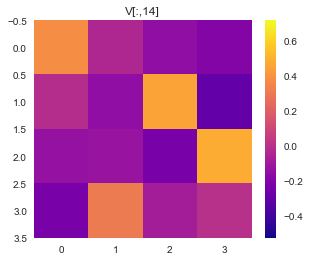

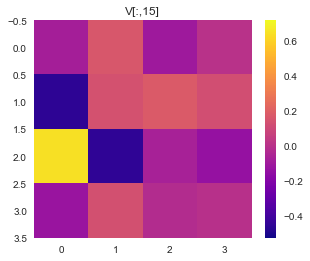

In [8]:
for n in range(nx*nz):
    plt.figure(figsize=(5,4))
    plt.imshow(V[:, n].reshape(nx, nz).T, cmap='plasma')
    plt.clim(cl)
    plt.grid()
    plt.colorbar()
    plt.title('V[:,{0:d}]'.format(n))
    plt.show()


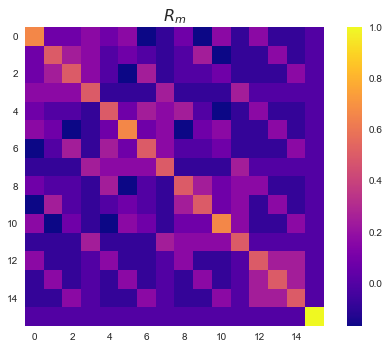

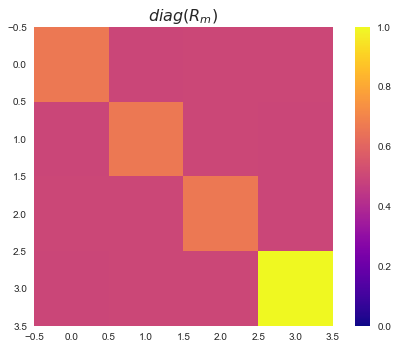

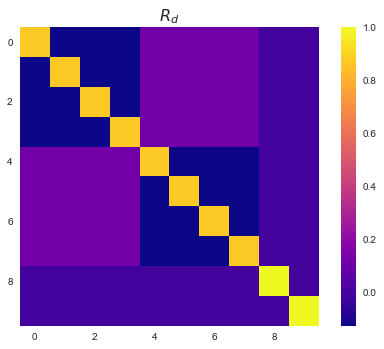

In [9]:
plt.imshow(Rm, cmap='plasma')
plt.grid()
plt.title('$R_{m}$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(np.diag(Rm).reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.title('$diag(R_{m})$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(Rd, cmap='plasma')
plt.grid()
plt.title('$R_{d}$', fontsize=16)
plt.colorbar()
plt.show()

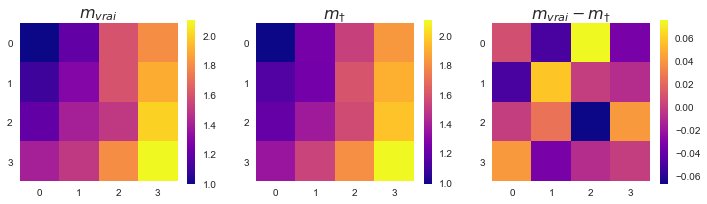

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

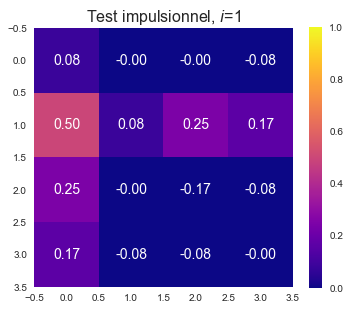

In [11]:
mi = np.zeros((nx*nz,))
mi[1] = 1

dtest = G @ mi
mtest = Gi @ dtest
res_kernel = Rm @ mi

plt.figure(figsize=(5.8, 4.8))
# plt.subplot(121)
plt.imshow(res_kernel.reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.colorbar()
for i in range(nx):
    for j in range(nz):
        plt.text(i, j, '{0:3.2f}'.format(res_kernel[i*nz+j]), color='white',
                 ha='center', va='center', fontsize=14)
plt.title('Test impulsionnel, $i$=1', fontsize=16)
plt.show()

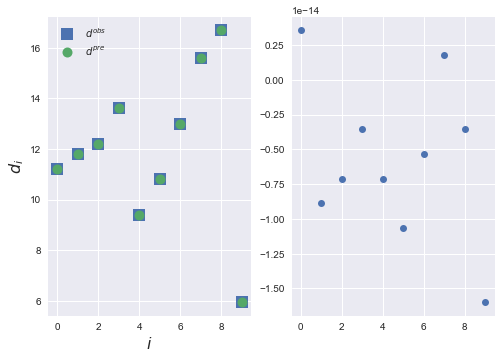

In [12]:
plt.subplot(121)
plt.plot(dobs, 's', MarkerSize=12, label='$d^{obs}$')
plt.plot(dpre, 'o', MarkerSize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', FontSize=16)
plt.xlabel('$i$', FontSize=16)

plt.subplot(122)
plt.plot(dobs-dpre, 'o')
plt.show()

## 2e expérience

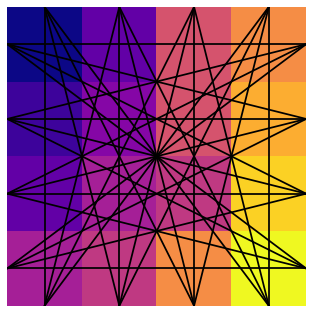

In [13]:
grx = h*np.arange(5.0)
grz = h*np.arange(5.0)

Tx = h*np.array([[0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5],
                 [0.0, 1.5], [0.0, 1.5], [0.0, 1.5], [0.0, 1.5],
                 [0.0, 2.5], [0.0, 2.5], [0.0, 2.5], [0.0, 2.5],
                 [0.0, 3.5], [0.0, 3.5], [0.0, 3.5], [0.0, 3.5],
                 [0.5, 0.0], [0.5, 0.0], [0.5, 0.0], [0.5, 0.0],
                 [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0],
                 [2.5, 0.0], [2.5, 0.0], [2.5, 0.0], [2.5, 0.0],
                 [3.5, 0.0], [3.5, 0.0], [3.5, 0.0], [3.5, 0.0]])

Rx = h*np.array([[4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0]])

Tx2 = Tx/h-0.5
Rx2 = Rx/h-0.5

plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
for n in range(Tx2.shape[0]):
    plt.plot((Tx2[n, 0], Rx2[n, 0]), (Tx2[n, 1], Rx2[n, 1]), '-k')
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
plt.show()

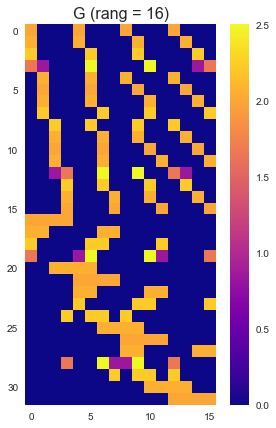

In [14]:
G = rgrid.Grid2d.data_kernel_straight_rays(Tx, Rx, grx, grz).toarray()

p = np.linalg.matrix_rank(G)

plt.figure(figsize=(5, 7))
plt.imshow(G, cmap='plasma')
plt.grid()
plt.colorbar()
plt.title('G (rang = {0:g})'.format(p), fontsize=16)
plt.show()

In [15]:
dobs = G @ mtrue

U, s, Vh = np.linalg.svd(G)
V = Vh.T
S = np.diag(s)

Vp = V[:, :p]
V0 = V[:, p:]
Sp = np.diag(s[:p])
Up = U[:, :p]
U0 = U[:, p:]

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))

mest = Gi @ dobs
dpre = G @ mest

Rm = Vp @ Vp.T
Rd = Up @ Up.T

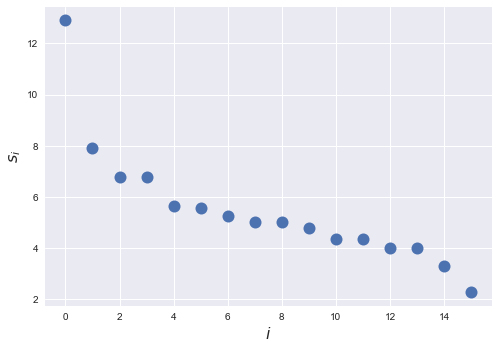

In [16]:
plt.plot(s, 'o', MarkerSize=12)
plt.ylabel('$s_i$', Fontsize=16)
plt.xlabel('$i$', Fontsize=16)
plt.show()

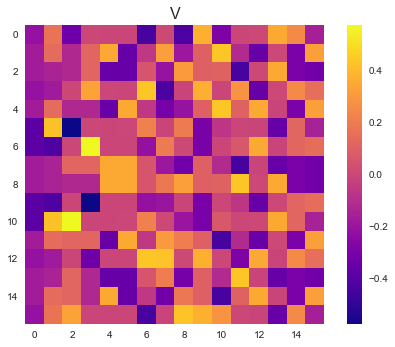

In [17]:
plt.imshow(V, cmap='plasma')
plt.grid()
plt.colorbar()
cl = plt.gci().get_clim()
plt.title('V', Fontsize=16)
plt.show()

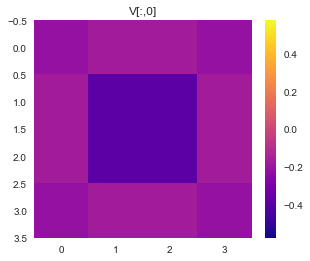

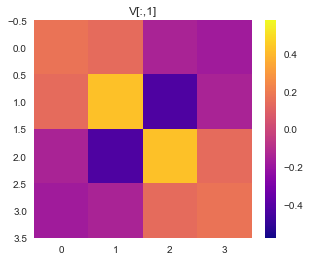

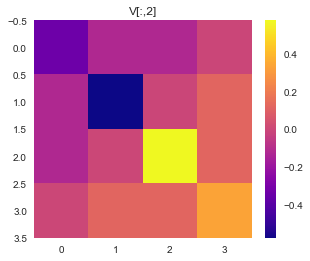

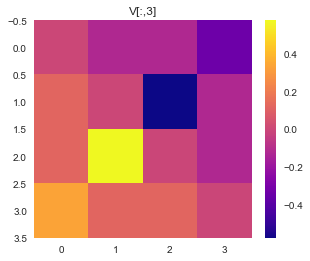

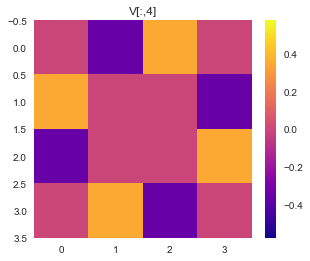

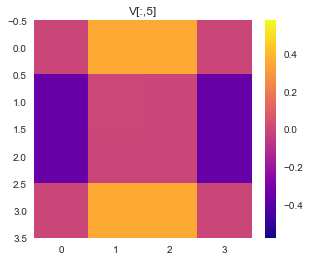

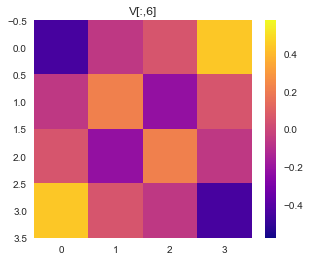

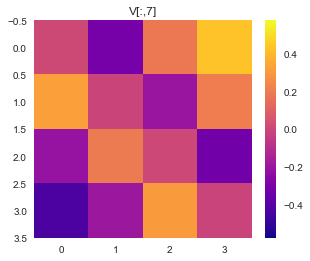

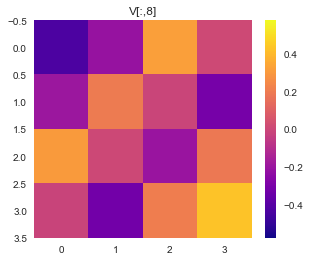

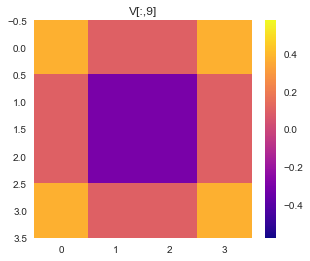

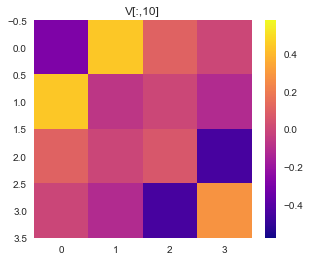

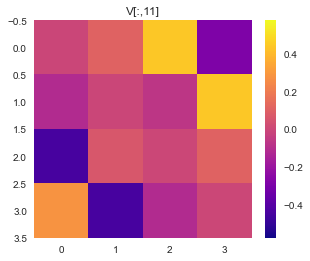

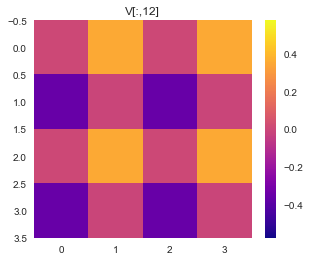

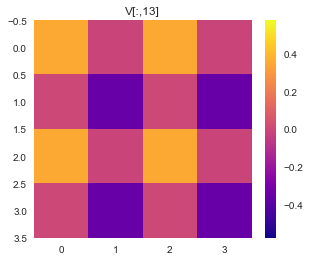

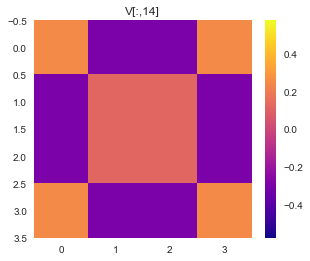

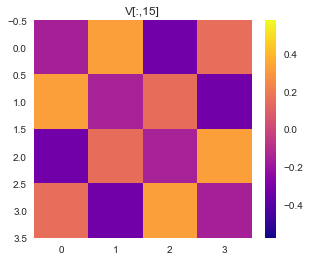

In [18]:
for n in range(nx*nz):
    plt.figure(figsize=(5,4))
    plt.imshow(V[:, n].reshape(nx, nz).T, cmap='plasma')
    plt.clim(cl)
    plt.grid()
    plt.colorbar()
    plt.title('V[:,{0:d}]'.format(n))
    plt.show()


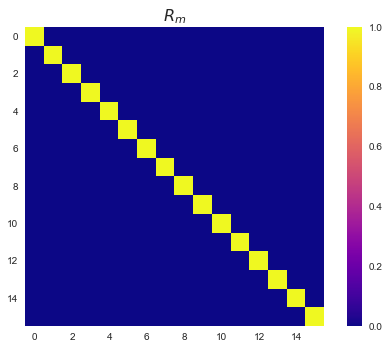

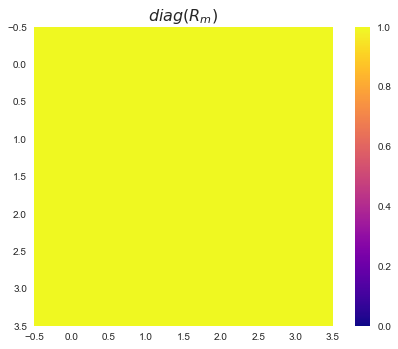

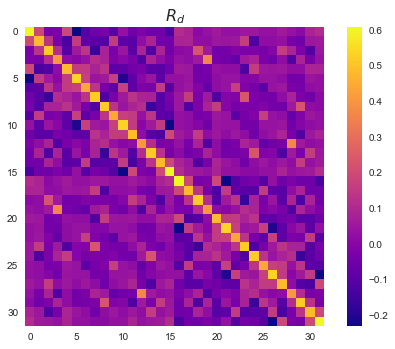

In [19]:
plt.imshow(Rm, cmap='plasma')
plt.grid()
plt.title('$R_{m}$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(np.diag(Rm).reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.title('$diag(R_{m})$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(Rd, cmap='plasma')
plt.grid()
plt.title('$R_{d}$', fontsize=16)
plt.colorbar()
plt.show()

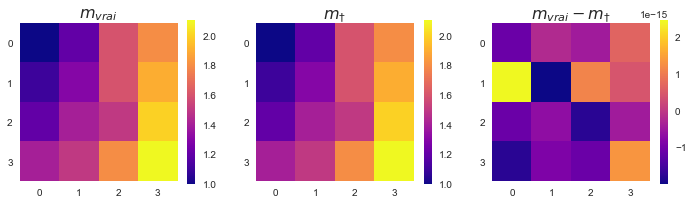

In [20]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

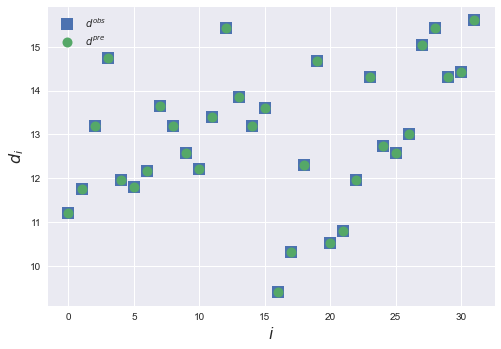

In [21]:
plt.plot(dobs, 's', MarkerSize=12, label='$d^{obs}$')
plt.plot(dpre, 'o', MarkerSize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', FontSize=16)
plt.xlabel('$i$', FontSize=16)
plt.show()

## Influence du bruit

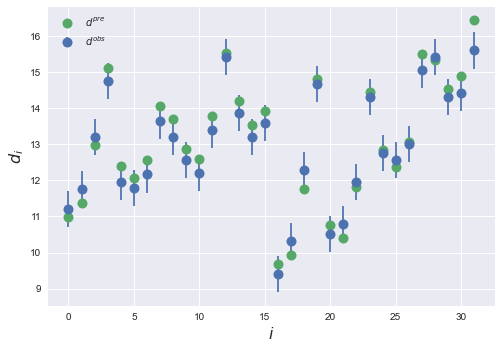

In [22]:
sd = 0.5
bruit = sd*np.random.randn(dobs.size)
dobs_b = dobs + bruit

mest = Gi @ dobs_b
dpre = G @ mest

plt.errorbar(np.arange(dobs.size), dobs, yerr=sd, fmt='o',
             MarkerSize=10, label='$d^{obs}$')
plt.plot(dpre, 'o', MarkerSize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', FontSize=16)
plt.xlabel('$i$', FontSize=16)
plt.show()

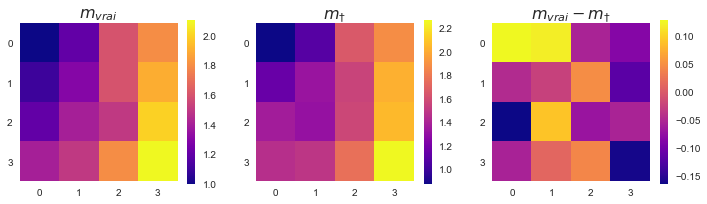

In [23]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

Le bruit dans les mesure entraîne inévitablement une erreur dans l'estimation des paramètres, même si la résolution est "parfaite".